In [1]:
# importing dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
#read csv
train_df = pd.read_csv("static/data/train_cleaned.csv")
test_df = pd.read_csv("static/data/test_cleaned.csv")

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Loan_ID            480 non-null    object
 1   Gender             480 non-null    object
 2   Married            480 non-null    object
 3   Dependents         480 non-null    object
 4   Education          480 non-null    object
 5   Self_Employed      480 non-null    object
 6   ApplicantIncome    480 non-null    int64 
 7   CoapplicantIncome  480 non-null    int64 
 8   LoanAmount         480 non-null    int64 
 9   Loan_Amount_Term   480 non-null    int64 
 10  Credit_History     480 non-null    int64 
 11  Property_Area      480 non-null    object
 12  Loan_Status        480 non-null    object
dtypes: int64(5), object(8)
memory usage: 48.9+ KB


In [4]:
## Dropping Loan ID
train_df = train_df.drop(columns=['Loan_ID']) 

In [5]:
#separate columns
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History','Loan_Amount_Term']
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


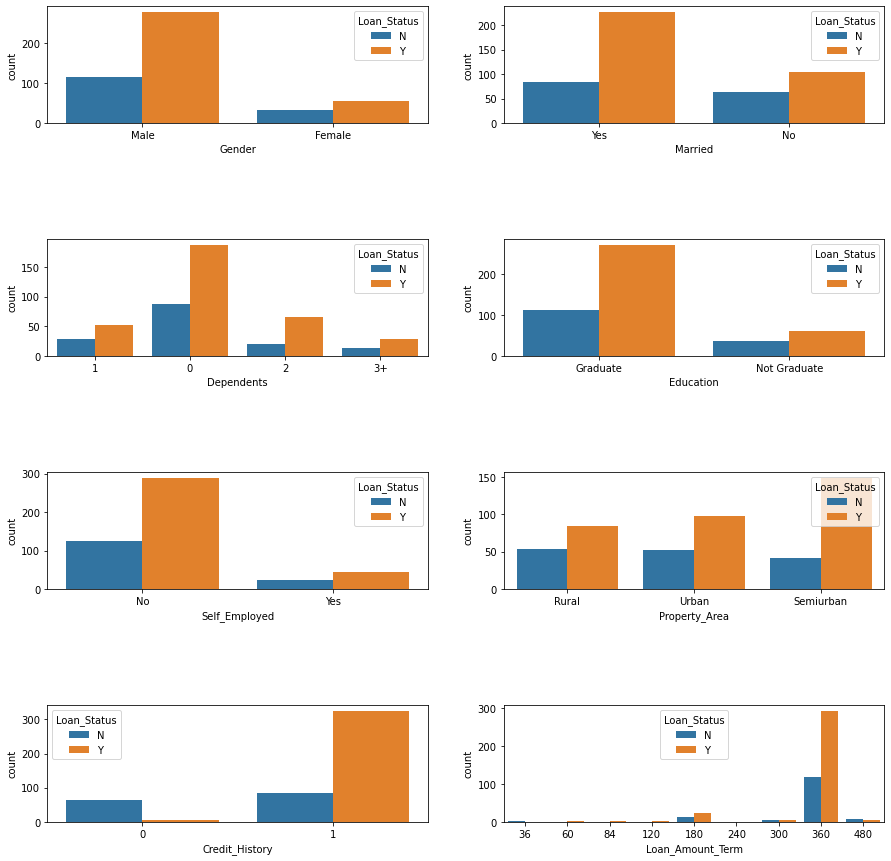

In [6]:
### Use visualization to check the loan_status with different variables

fig,axes = plt.subplots(4,2,figsize=(15,15))
for idx,cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=train_df,hue='Loan_Status',ax=axes[row,col])

plt.subplots_adjust(hspace=1)

In [7]:
##get to know numerical data
print(train_df[numerical_columns].describe())

       ApplicantIncome  CoapplicantIncome     LoanAmount
count       480.000000         480.000000     480.000000
mean      64370.775000       18973.100000  144735.416667
std       68019.015008       31412.313561   80508.164214
min        1800.000000           0.000000    9000.000000
25%       34785.000000           0.000000  100000.000000
50%       46308.000000       13014.000000  128000.000000
75%       70230.000000       27039.000000  170000.000000
max      972000.000000      406044.000000  600000.000000


In [8]:
#prepare the data for machine learning by encoding the data
train_df_encoded = pd.get_dummies(train_df)
# Gender_Male: male = 1, female = 0
# Married_Yes: yes = 1, no = 0
# Education_Graduate: grad = 1, not grad = 0
# Self_Employed_Yes: yes = 1, no = 0
# Loan_Status_Y: yes = 1, no = 0 
train_df_encoded = train_df_encoded.drop(columns=['Gender_Female', 'Married_No', 'Education_Not Graduate', 'Self_Employed_No', 'Loan_Status_N'])
train_df_encoded.head()


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,54996,18096,128000,360,1,1,1,0,1,0,0,1,0,1,0,0,0
1,36000,0,66000,360,1,1,1,1,0,0,0,1,1,0,0,1,1
2,30996,28296,120000,360,1,1,1,1,0,0,0,0,0,0,0,1,1
3,72000,0,141000,360,1,1,0,1,0,0,0,1,0,0,0,1,1
4,65004,50352,267000,360,1,1,1,0,0,1,0,1,1,0,0,1,1


In [9]:
#Split Features and Target Varible
X = train_df_encoded.drop(columns='Loan_Status_Y')
y = train_df_encoded['Loan_Status_Y']

#Splitting into Train-Test Data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify =y,random_state =42)

In [10]:
##Model 1: Decision Tree Classifier

model1 = DecisionTreeClassifier()
model1.fit(X_train,y_train)
y_pred = model1.predict(X_train)
print("Training Data Set Accuracy: ", accuracy_score(y_train,y_pred))
print("Training Data F1 Score ", f1_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(model1,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(model1,X_train,y_train,cv=5,scoring='accuracy').mean())

Training Data Set Accuracy:  1.0
Training Data F1 Score  1.0
Validation Mean F1 Score:  0.6364614504239413
Validation Mean Accuracy:  0.684688995215311


In [11]:
#above showed the overfitting issue because the accuracy and F1 score are both 1

In [12]:

training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
min_samples_leaf = []

for samples_leaf in range(1,80,3): ### Sweeping from 1% samples to 10% samples per leaf 
    tree_clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf = samples_leaf)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    min_samples_leaf.append(samples_leaf)

<AxesSubplot:xlabel='Min_Samples_leaf', ylabel='Values'>

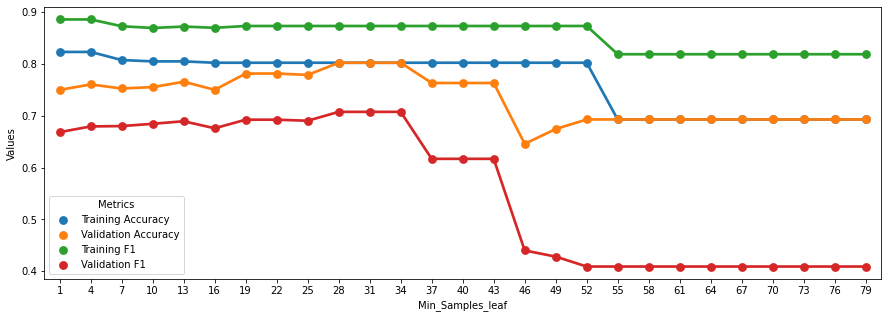

In [13]:
#show the accuracy and validation
Tuning_min_samples_leaf = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Min_Samples_leaf": min_samples_leaf }
Tuning_min_samples_leaf_df = pd.DataFrame.from_dict(Tuning_min_samples_leaf)

plot_df = Tuning_min_samples_leaf_df.melt('Min_Samples_leaf',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Min_Samples_leaf", y="Values",hue="Metrics", data=plot_df,ax=ax)

In [14]:
#train the the data before the accuracy drops
model1 = DecisionTreeClassifier(max_depth=3,min_samples_leaf = 35)
model1.fit(X_train,y_train)
y_pred = model1.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
confusion_matrix(y_test,y_pred)
#pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

#true negative:64, false positive is high:14, people shouldnt get approved will be approved

Test Accuracy:  0.8333333333333334
Test F1 Score:  0.8888888888888888
Confusion Matrix on Test Data


array([[16, 14],
       [ 2, 64]], dtype=int64)

In [15]:
#Model 2: Random Forest Classifier

model2 = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
model2.fit(X_train,y_train)
y_pred = model2.predict(X_train)
print("Train F1 Score ", f1_score(y_train,y_pred))
print("Train Accuracy ", accuracy_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(model2,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(model2,X_train,y_train,cv=5,scoring='accuracy').mean())

Train F1 Score  0.8729096989966555
Train Accuracy  0.8020833333333334
Validation Mean F1 Score:  0.7019605847413943
Validation Mean Accuracy:  0.8020164046479836


In [16]:
y_predict = model2.predict(X_test)
print("Test F1 Score: ",f1_score(y_test,y_predict))
print("Test Accuracy: ",accuracy_score(y_test,y_predict))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_predict, rownames=['True'], colnames=['Predicted'], margins=True)

Test F1 Score:  0.8888888888888888
Test Accuracy:  0.8333333333333334
Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,16,14,30
1,2,64,66
All,18,78,96


In [17]:
#Model 3: Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict



In [18]:
train_accuracies = []
train_f1_scores = []
test_accuracies = []
test_f1_scores = []
thresholds = []

for thresh in np.arange(0.1,0.9,0.1): ## Sweeping from threshold of 0.1 to 0.9
    model3= LogisticRegression(solver='liblinear')
    model3.fit(X_train,y_train)
    
    y_pred_train_thresh = model3.predict_proba(X_train)[:,1]
    y_pred_train = (y_pred_train_thresh > thresh).astype(int)

    train_acc = accuracy_score(y_train,y_pred_train)
    train_f1 = f1_score(y_train,y_pred_train)
    
    y_pred_test_thresh = model3.predict_proba(X_test)[:,1]
    y_pred_test = (y_pred_test_thresh > thresh).astype(int) 
    
    test_acc = accuracy_score(y_test,y_pred_test)
    test_f1 = f1_score(y_test,y_pred_test)
    
    train_accuracies.append(train_acc)
    train_f1_scores.append(train_f1)
    test_accuracies.append(test_acc)
    test_f1_scores.append(test_f1)
    thresholds.append(thresh)

<AxesSubplot:xlabel='Decision Threshold', ylabel='Values'>

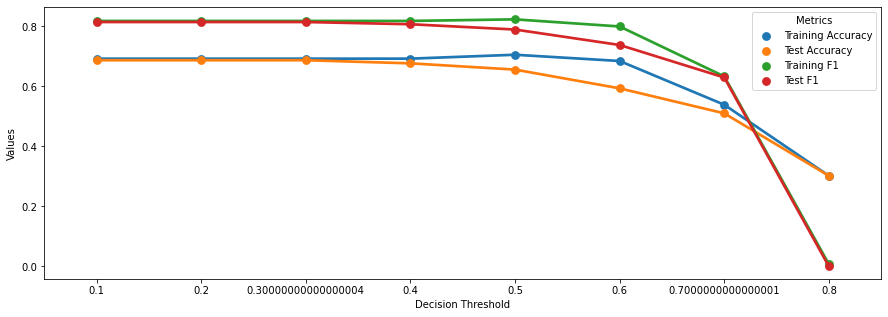

In [19]:
Threshold_logreg = {"Training Accuracy": train_accuracies, "Test Accuracy": test_accuracies, "Training F1": train_f1_scores, "Test F1":test_f1_scores, "Decision Threshold": thresholds }
Threshold_logreg_df = pd.DataFrame.from_dict(Threshold_logreg)

plot_df = Threshold_logreg_df.melt('Decision Threshold',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Decision Threshold", y="Values",hue="Metrics", data=plot_df,ax=ax)

In [20]:
thresh = 0.4 ### Threshold chosen from above Curves
y_pred_test_thresh = model3.predict_proba(X_test)[:,1]
y_pred = (y_pred_test_thresh > thresh).astype(int) 
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.6770833333333334
Test F1 Score:  0.8074534161490684
Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,0,30,30
1,1,65,66
All,1,95,96


In [21]:
#true positive is too high 

In [22]:
#Create the GridReseach
# Create the GridSearchCV model
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10],
              'penalty': ["l1", "l2"]}
model = LogisticRegression(solver='liblinear')
grid = GridSearchCV(model, param_grid, verbose=3)

In [23]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................................C=1, penalty=l1; total time=   0.0s
[CV 2/5] END ................................C=1, penalty=l1; total time=   0.0s
[CV 3/5] END ................................C=1, penalty=l1; total time=   0.0s
[CV 4/5] END ................................C=1, penalty=l1; total time=   0.0s
[CV 5/5] END ................................C=1, penalty=l1; total time=   0.0s
[CV 1/5] END ................................C=1, penalty=l2; total time=   0.0s
[CV 2/5] END ................................C=1, penalty=l2; total time=   0.0s
[CV 3/5] END ................................C=1, penalty=l2; total time=   0.0s
[CV 4/5] END ................................C=1, penalty=l2; total time=   0.0s
[CV 5/5] END ................................C=1, penalty=l2; total time=   0.0s
[CV 1/5] END ................................C=5, penalty=l1; total time=   0.0s
[CV 2/5] END ................................C=5,

GridSearchCV(estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [1, 5, 10], 'penalty': ['l1', 'l2']}, verbose=3)

In [24]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 1, 'penalty': 'l1'}
0.7994531784005469


In [25]:
model3 = LogisticRegression(solver='liblinear',C= 1, penalty='l1',max_iter=1000)

In [26]:
model3.fit(X_train,y_train)

LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='liblinear')

In [27]:
y_training_pred = model3.predict(X_train)
y_testing_pred = model3.predict(X_test)

In [28]:
print("Test Accuracy: ",accuracy_score(y_test,y_testing_pred))
print("Test F1 Score: ",f1_score(y_test,y_testing_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_testing_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.8333333333333334
Test F1 Score:  0.8873239436619719
Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,17,13,30
1,3,63,66
All,20,76,96


In [29]:
print("Train Accuracy: ",accuracy_score(y_train,y_training_pred))
print("Train F1 Score: ",f1_score(y_train,y_training_pred))
print("Confusion Matrix on Train Data")
pd.crosstab(y_train, y_training_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Train Accuracy:  0.8203125
Train F1 Score:  0.8832487309644669
Confusion Matrix on Train Data


Predicted,0,1,All
True,,,
0,54,64,118
1,5,261,266
All,59,325,384


#Decision tree:over fitting
#Random Forest: accuracy is lower and 
Training Data Score: 0.9765625
Testing Data Score: 0.75
#Logistic regression

In [30]:
import joblib
filename = 'logistic.joblib'
joblib.dump(model3, filename)

['logistic.joblib']